# Model Misspecification in SBI

**Session 6** - Hands-on exercise (~35 min)

In this notebook, we'll:
1. **Experience** misspecification: Train NPE on a simplified simulator, then evaluate on more realistic data
2. **Detect** misspecification using methods from the `sbi` package
3. **Understand** why detection matters and what to do when misspecification is found

## 1. The Problem: All Models Are Wrong

Our Lotka-Volterra simulator makes simplifying assumptions. One key assumption:

**Standard LV:** Predation rate is linear in prey density
$$\text{Prey eaten} = \beta \cdot x \cdot y$$

**Reality:** Predators have limited consumption capacity (they need time to handle/digest prey)
$$\text{Prey eaten} = \frac{\beta \cdot x \cdot y}{1 + h \cdot x}$$

This is called a **Type II functional response** (Holling, 1959). The parameter $h$ is the "handling time".

When $h = 0$, we recover standard LV. When $h > 0$, predation saturates at high prey densities.

**The scenario:**
- We did not know about the Type II functional response and train NPE on our standard LV simulator ($h = 0$)
- Then we apply our trained posterior estimator to real data to make predictions or draw conclusions
- But the "real" observation comes from a system with predator saturation ($h > 0$)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from functools import partial

from sbi.inference import NPE, simulate_for_sbi

from simulators import (
    create_lotka_volterra_prior,
    lotka_volterra_simulator,
    simulate,
)
from simulators.lotka_volterra import summarize_simulation, _get_stats
from utils import corner_plot

## 2. Setup: Two Simulators

We'll create two versions of the Lotka-Volterra simulator:
1. **Training simulator**: Standard LV (what we assume)
2. **Misspecified simulator**: LV with Type II functional response (closer to reality)

In [2]:
# Configuration
USE_AUTOCORRELATION = True

def lotka_volterra_ode(y: np.ndarray, alpha: float, beta: float, delta: float, gamma: float) -> np.ndarray:
    """Standard Lotka-Volterra differential equations (no predator saturation)."""
    deer, wolves = y
    ddeer_dt = alpha * deer - beta * deer * wolves
    dwolves_dt = delta * deer * wolves - gamma * wolves
    return np.asarray([ddeer_dt, dwolves_dt])

def lotka_volterra_ode_typeII(y: np.ndarray, alpha: float, beta: float, delta: float, gamma: float, h: float) -> np.ndarray:
    """Lotka-Volterra with Type II functional response (predator saturation).
    
    The parameter h is the handling time. When h=0, this reduces to standard LV.
    Larger h means more saturation (predators can't eat unlimited prey).
    """
    deer, wolves = y
    # Functional response: predation rate saturates at high prey density
    functional_response = (beta * deer) / (1 + h * deer)
    ddeer_dt = alpha * deer - functional_response * wolves
    dwolves_dt = delta * functional_response * wolves / beta - gamma * wolves
    return np.asarray([ddeer_dt, dwolves_dt])

def simulate_typeII(parameters: np.ndarray, h: float = 0.02, time_span: float = 200.0) -> np.ndarray:
    """Simulate deer-wolf dynamics with Type II functional response.
    
    Uses same initial conditions and time step as the standard simulator for consistency.
    """
    alpha, beta, delta, gamma = parameters
    
    initial_populations = np.asarray([40.0, 9.0])  # Same as standard simulator
    dt = 0.1
    
    timesteps = int(time_span / dt)
    populations = np.zeros((timesteps, 2))
    populations[0] = initial_populations
    
    for i in range(1, timesteps):
        populations[i] = (
            populations[i - 1]
            + lotka_volterra_ode_typeII(populations[i - 1], alpha, beta, delta, gamma, h) * dt
        )
    
    return populations

def misspecified_simulator(params: torch.Tensor, handling_time: float = 0.02) -> torch.Tensor:
    """LV simulator with Type II functional response (misspecified).
    
    Uses the same summary statistics pipeline as the standard simulator.
    """
    if isinstance(params, torch.Tensor):
        params_np = params.detach().cpu().numpy()
    else:
        params_np = np.array(params)
    
    if params_np.ndim == 1:
        params_np = params_np.reshape(1, -1)
    
    batch_size = params_np.shape[0]
    batch_summaries = []
    
    for i in range(batch_size):
        # Simulate with Type II functional response
        simulation_result = simulate_typeII(params_np[i], h=handling_time)
        # Use same summary statistics as standard simulator
        summary_stats = summarize_simulation(simulation_result, use_autocorrelation=USE_AUTOCORRELATION)
        batch_summaries.append(summary_stats)
    
    return torch.tensor(np.array(batch_summaries), dtype=torch.float32)

# Create standard simulator wrapper for consistency
standard_simulator = partial(lotka_volterra_simulator, use_autocorrelation=USE_AUTOCORRELATION)

## 3. Visualize the Difference

Let's see how the Type II functional response changes the dynamics.

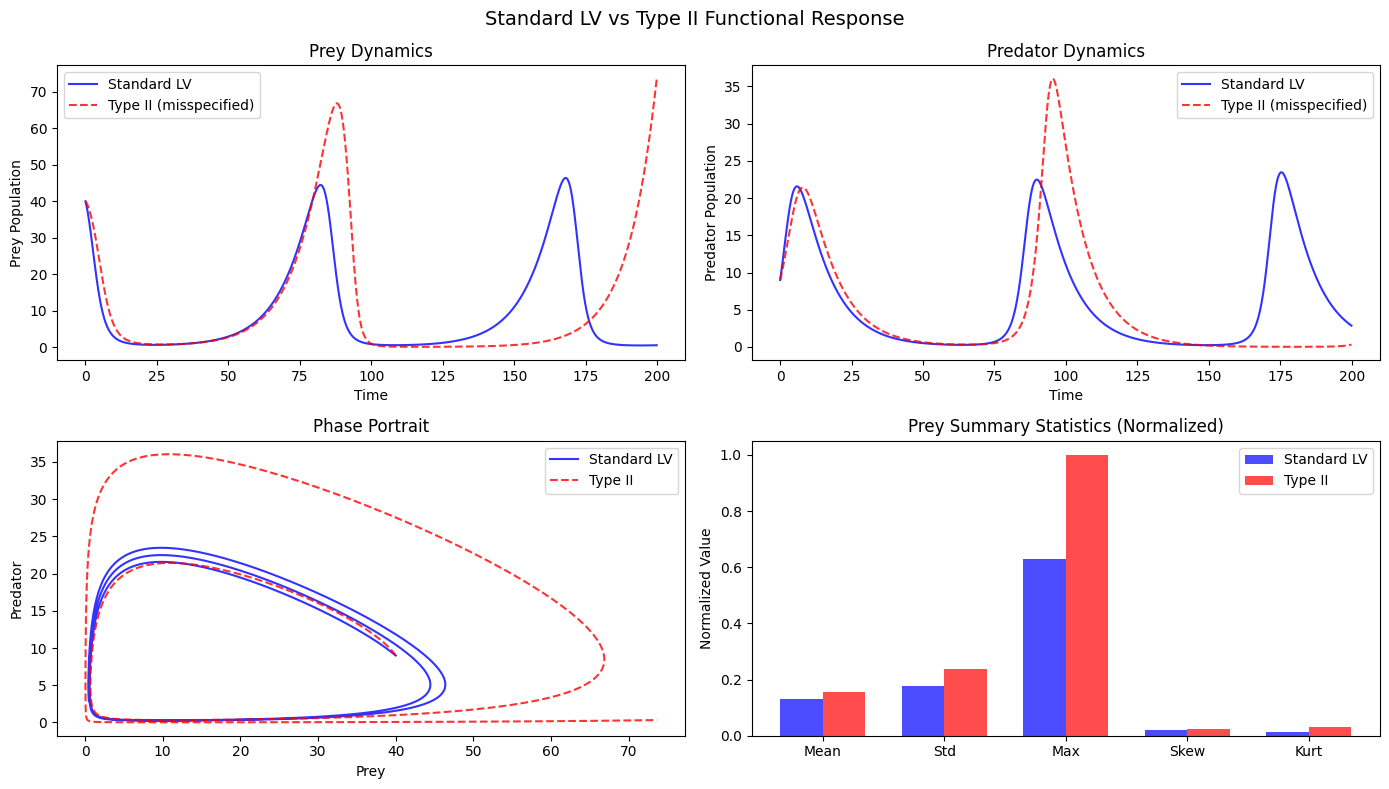

In [3]:
# True parameters (same as used in other notebooks)
theta_true = torch.tensor([0.1, 0.02, 0.01, 0.1])
alpha, beta, delta, gamma = theta_true.numpy()

# Time array
time_span = 200.0
dt = 0.1
t = np.arange(0, time_span, dt)

# Simulate both models using consistent initial conditions
sol_standard = simulate(theta_true.numpy())  # Uses existing simulator
sol_typeII = simulate_typeII(theta_true.numpy(), h=0.01)

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Prey comparison
ax = axes[0, 0]
ax.plot(t, sol_standard[:, 0], 'b-', label='Standard LV', alpha=0.8)
ax.plot(t, sol_typeII[:, 0], 'r--', label='Type II (misspecified)', alpha=0.8)
ax.set_xlabel('Time')
ax.set_ylabel('Prey Population')
ax.set_title('Prey Dynamics')
ax.legend()

# Predator comparison
ax = axes[0, 1]
ax.plot(t, sol_standard[:, 1], 'b-', label='Standard LV', alpha=0.8)
ax.plot(t, sol_typeII[:, 1], 'r--', label='Type II (misspecified)', alpha=0.8)
ax.set_xlabel('Time')
ax.set_ylabel('Predator Population')
ax.set_title('Predator Dynamics')
ax.legend()

# Phase portrait
ax = axes[1, 0]
ax.plot(sol_standard[:, 0], sol_standard[:, 1], 'b-', label='Standard LV', alpha=0.8)
ax.plot(sol_typeII[:, 0], sol_typeII[:, 1], 'r--', label='Type II', alpha=0.8)
ax.set_xlabel('Prey')
ax.set_ylabel('Predator')
ax.set_title('Phase Portrait')
ax.legend()

# Summary statistics comparison (without noise, just to show the structural difference)
ax = axes[1, 1]
stats_standard = _get_stats(sol_standard[:, 0], use_autocorrelation=False)  # Prey only, no noise
stats_typeII = _get_stats(sol_typeII[:, 0], use_autocorrelation=False)

stat_names = ['Mean', 'Std', 'Max', 'Skew', 'Kurt']
x_pos = np.arange(len(stat_names))
width = 0.35

# Normalize for visualization
max_abs = np.maximum(np.abs(stats_standard).max(), np.abs(stats_typeII).max())
prey_standard = stats_standard / max_abs
prey_typeII = stats_typeII / max_abs

ax.bar(x_pos - width/2, prey_standard, width, label='Standard LV', color='b', alpha=0.7)
ax.bar(x_pos + width/2, prey_typeII, width, label='Type II', color='r', alpha=0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(stat_names)
ax.set_ylabel('Normalized Value')
ax.set_title('Prey Summary Statistics (Normalized)')
ax.legend()

plt.suptitle('Standard LV vs Type II Functional Response', fontsize=14)
plt.tight_layout()
plt.show()

### What do we observe?

The Type II functional response causes:
- **Lower peak amplitudes**: Predators can't exploit prey booms as effectively
- **Different oscillation patterns**: The dynamics are subtly different
- **Changed summary statistics**: Mean, std, max, and autocorrelation all differ

This is exactly the kind of subtle mismatch that can cause problems for NPE!

## 4. Train NPE on Standard Simulator

Now let's train NPE assuming our standard LV model is correct.

In [4]:
# Configuration
NUM_SIMULATIONS = 20000
NUM_WORKERS = 10

# Create prior (same as other notebooks)
prior = create_lotka_volterra_prior()

print(f"Prior bounds: {prior.base_dist.low.numpy()} to {prior.base_dist.high.numpy()}")
print(f"True parameters: {theta_true.numpy()}")

Prior bounds: [0.05  0.01  0.005 0.005] to [0.15 0.03 0.03 0.15]
True parameters: [0.1  0.02 0.01 0.1 ]


In [5]:
# Generate training data with STANDARD simulator (this is what we assume is correct)
print(f"Generating {NUM_SIMULATIONS} simulations with standard LV simulator...")
theta_train, x_train = simulate_for_sbi(standard_simulator, prior, NUM_SIMULATIONS, num_workers=NUM_WORKERS)

print(f"Training data shapes: theta={theta_train.shape}, x={x_train.shape}")
print(f"Summary statistics dimension: {x_train.shape[1]}")

Generating 20000 simulations with standard LV simulator...


  0%|          | 0/20000 [00:00<?, ?it/s]

Training data shapes: theta=torch.Size([20000, 4]), x=torch.Size([20000, 20])
Summary statistics dimension: 20


In [6]:
# Train NPE
print("Training NPE...")
trainer = NPE(prior)
trainer.append_simulations(theta_train, x_train)
trainer.train(training_batch_size=1000)

posterior = trainer.build_posterior()

Training NPE...
 Neural network successfully converged after 366 epochs.

## 5. Exercise 1: Experience Misspecification

Now let's see what happens when we use NPE with a misspecified observation.

In [7]:
# Generate observations
x_o_wellspec = standard_simulator(theta_true)      # Well-specified (from training distribution)
x_o_misspec = misspecified_simulator(theta_true)   # Misspecified (Type II functional response)

print(f"Well-specified observation shape: {x_o_wellspec.shape}")
print(f"Misspecified observation shape: {x_o_misspec.shape}")

Well-specified observation shape: torch.Size([1, 20])
Misspecified observation shape: torch.Size([1, 20])


In [8]:
# Sample from posterior for both observations
print("Sampling from posterior...")
samples_wellspec = posterior.sample((5000,), x=x_o_wellspec)
samples_misspec = posterior.sample((5000,), x=x_o_misspec)

print(f"\nWell-specified observation:")
print(f"  Posterior mean: {samples_wellspec.mean(dim=0).numpy()}")
print(f"  Posterior std:  {samples_wellspec.std(dim=0).numpy()}")
print(f"  True params:    {theta_true.numpy()}")

print(f"\nMisspecified observation:")
print(f"  Posterior mean: {samples_misspec.mean(dim=0).numpy()}")
print(f"  Posterior std:  {samples_misspec.std(dim=0).numpy()}")
print(f"  True params:    {theta_true.numpy()}")

Sampling from posterior...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


Well-specified observation:
  Posterior mean: [0.10208139 0.02034343 0.00985829 0.09835978]
  Posterior std:  [0.00329147 0.00085723 0.00042023 0.0023201 ]
  True params:    [0.1  0.02 0.01 0.1 ]

Misspecified observation:
  Posterior mean: [0.09693887 0.01642971 0.02650893 0.10635921]
  Posterior std:  [0.00231757 0.00210342 0.00207542 0.01001714]
  True params:    [0.1  0.02 0.01 0.1 ]


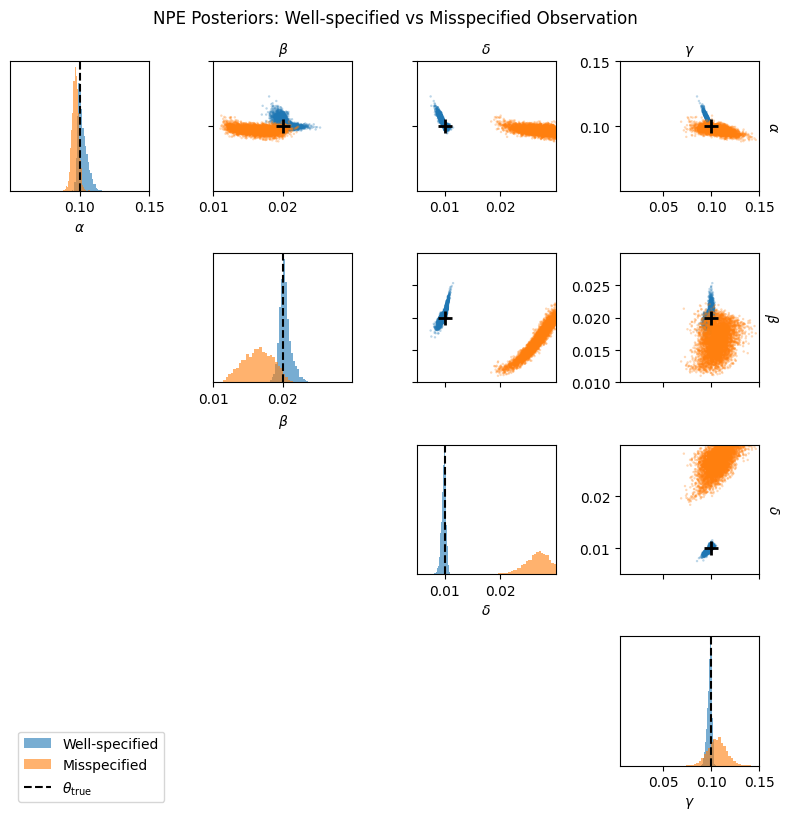

In [9]:
# Visualize posteriors
param_names = [r"$\alpha$", r"$\beta$", r"$\delta$", r"$\gamma$"]
prior_limits = [[prior.base_dist.low[i].item(), prior.base_dist.high[i].item()] for i in range(4)]

fig, axes = corner_plot(
    [samples_wellspec, samples_misspec],
    labels=["Well-specified", "Misspecified"],
    param_names=param_names,
    theta_true=theta_true,
    limits=prior_limits,
)
plt.suptitle('NPE Posteriors: Well-specified vs Misspecified Observation', y=1.02, fontsize=12)
plt.show()

### Discussion

**What do you observe?**
- The posterior given the well-specified data covers the true parameters
- The misspecified posterior is shifted and/or has different uncertainty

**The problem:** With real data, we don't know $\theta_{true}$, so we can't tell if the posterior is wrong!

**This is why we need detection methods.**

### Posterior Predictive Check

Let's also check if posterior samples produce data similar to the observation. This is a useful diagnostic even before formal detection.

In [10]:
# Generate posterior predictive samples for both posteriors
n_predictive = 50

# Well-specified: sample parameters from posterior, simulate with standard simulator
pred_theta_wellspec = samples_wellspec[:n_predictive]
pred_x_wellspec = standard_simulator(pred_theta_wellspec)

# Misspecified: sample parameters from posterior, simulate with standard simulator
# Note: we use the standard simulator because that's what NPE was trained on
pred_theta_misspec = samples_misspec[:n_predictive]
pred_x_misspec = standard_simulator(pred_theta_misspec)

# Generate time series for visualization
ts_wellspec = [simulate(pred_theta_wellspec[i].numpy()) for i in range(n_predictive)]
ts_misspec = [simulate(pred_theta_misspec[i].numpy()) for i in range(n_predictive)]

# Ground truth time series
ts_observed_wellspec = simulate(theta_true.numpy())
ts_observed_misspec = simulate_typeII(theta_true.numpy(), h=0.02)  # What actually generated the misspecified observation

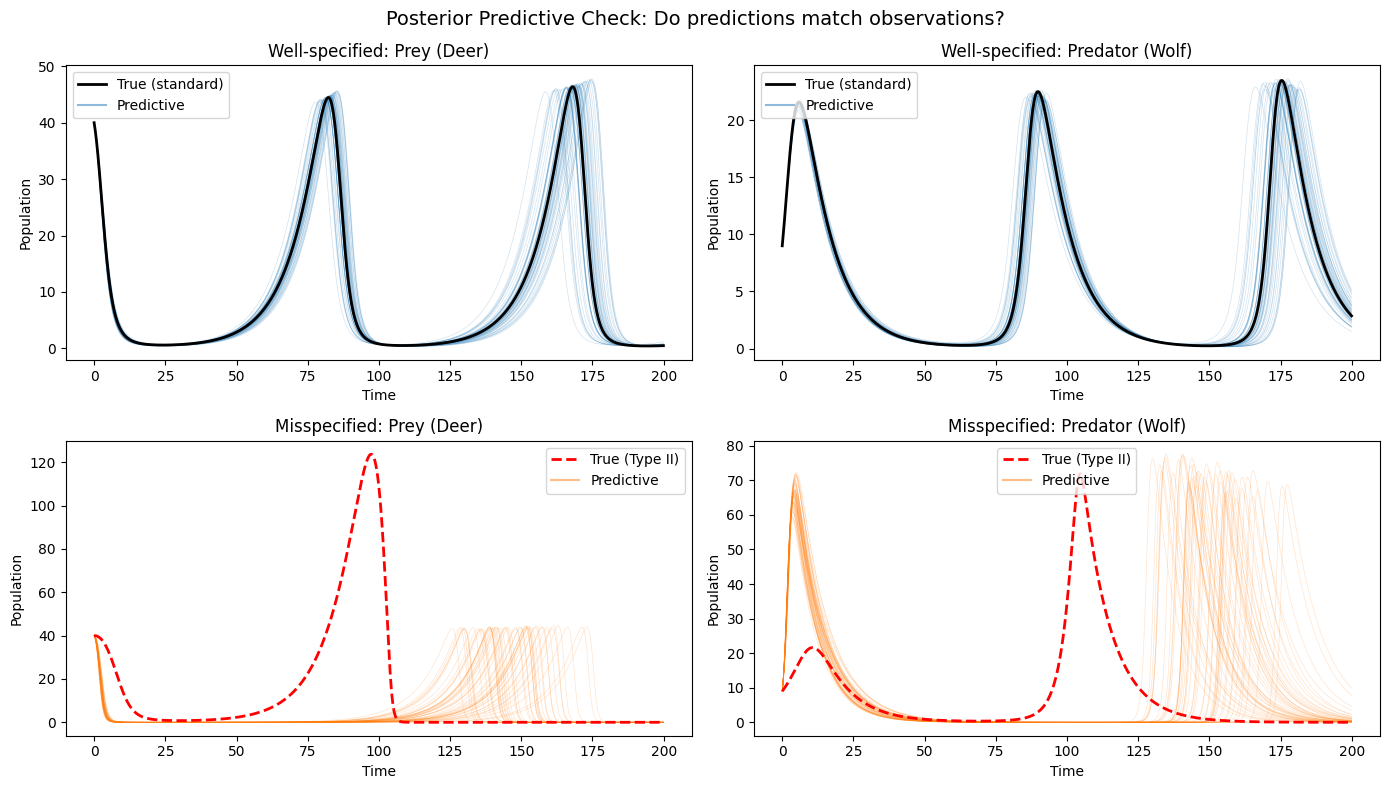


Key observation:
  - Well-specified: Predictive samples should bracket the true trajectory
  - Misspecified: Predictive samples may systematically miss the true trajectory
    (because the true data came from Type II dynamics, not standard LV)


In [11]:
# Visualize posterior predictive: Time series comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Well-specified - Prey
ax = axes[0, 0]
for ts in ts_wellspec:
    ax.plot(t, ts[:, 0], color="C0", alpha=0.2, linewidth=0.5)
ax.plot(t, ts_observed_wellspec[:, 0], color="k", linewidth=2, label="True (standard)")
ax.plot([], [], color="C0", alpha=0.5, label="Predictive")
ax.set_xlabel("Time")
ax.set_ylabel("Population")
ax.set_title("Well-specified: Prey (Deer)")
ax.legend()

# Well-specified - Predator
ax = axes[0, 1]
for ts in ts_wellspec:
    ax.plot(t, ts[:, 1], color="C0", alpha=0.2, linewidth=0.5)
ax.plot(t, ts_observed_wellspec[:, 1], color="k", linewidth=2, label="True (standard)")
ax.plot([], [], color="C0", alpha=0.5, label="Predictive")
ax.set_xlabel("Time")
ax.set_ylabel("Population")
ax.set_title("Well-specified: Predator (Wolf)")
ax.legend()

# Misspecified - Prey
ax = axes[1, 0]
for ts in ts_misspec:
    ax.plot(t, ts[:, 0], color="C1", alpha=0.2, linewidth=0.5)
ax.plot(t, ts_observed_misspec[:, 0], color="r", linewidth=2, linestyle='--', label="True (Type II)")
ax.plot([], [], color="C1", alpha=0.5, label="Predictive")
ax.set_xlabel("Time")
ax.set_ylabel("Population")
ax.set_title("Misspecified: Prey (Deer)")
ax.legend()

# Misspecified - Predator
ax = axes[1, 1]
for ts in ts_misspec:
    ax.plot(t, ts[:, 1], color="C1", alpha=0.2, linewidth=0.5)
ax.plot(t, ts_observed_misspec[:, 1], color="r", linewidth=2, linestyle='--', label="True (Type II)")
ax.plot([], [], color="C1", alpha=0.5, label="Predictive")
ax.set_xlabel("Time")
ax.set_ylabel("Population")
ax.set_title("Misspecified: Predator (Wolf)")
ax.legend()

plt.suptitle("Posterior Predictive Check: Do predictions match observations?", fontsize=14)
plt.tight_layout()
plt.show()

print("\nKey observation:")
print("  - Well-specified: Predictive samples should bracket the true trajectory")
print("  - Misspecified: Predictive samples may systematically miss the true trajectory")
print("    (because the true data came from Type II dynamics, not standard LV)")

## 6. Detection Method 1: Prior Predictive Check

The simplest check: do simulations from our model look like the observation?

Generate many simulations from the prior and visually compare to $x_o$.

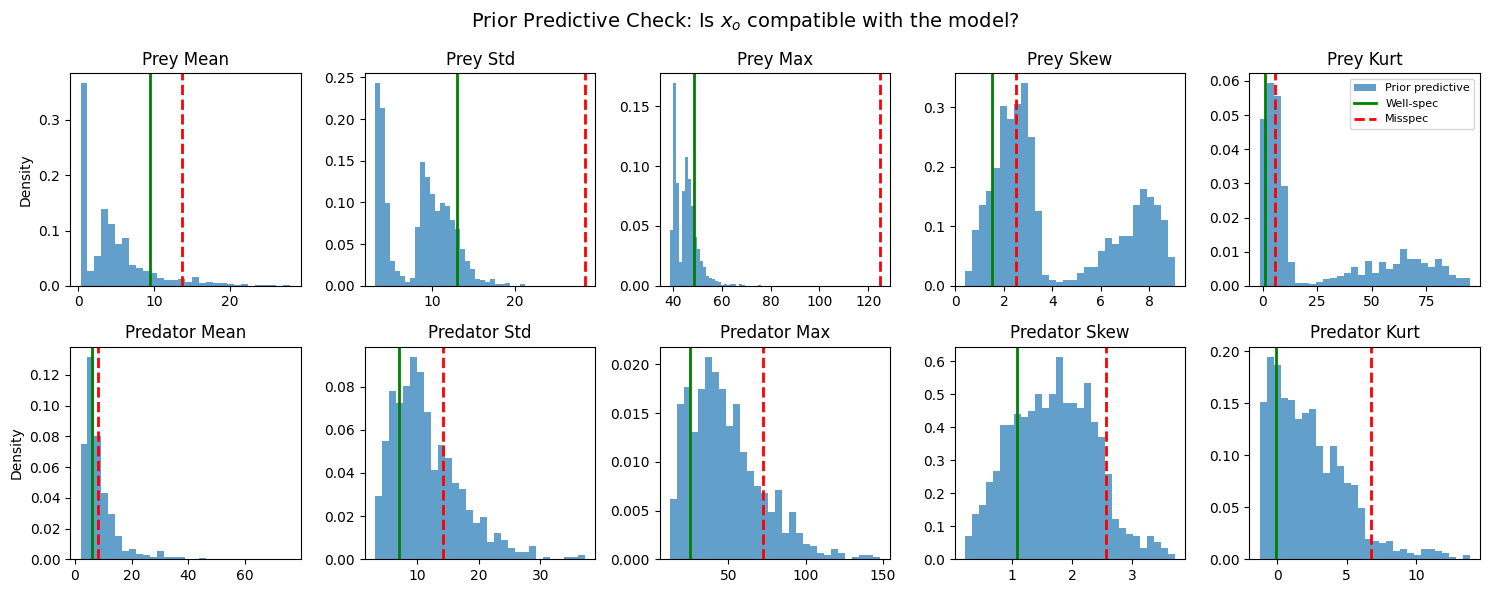

In [12]:
# Prior predictive check: compare x_o to prior predictive distribution
n_prior_samples = 1000

# We already have training data, let's use a subset
x_prior_samples = x_train[:n_prior_samples]

# Select a few summary statistics to visualize (moments only, first 5 for prey)
stat_names = ['Mean', 'Std', 'Max', 'Skew', 'Kurt']

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, name in enumerate(stat_names):
    # Prey statistics (indices 0-4)
    ax = axes[0, i]
    ax.hist(x_prior_samples[:, i].numpy(), bins=30, alpha=0.7, density=True, label='Prior predictive')
    ax.axvline(x_o_wellspec[0, i].item(), color='g', linewidth=2, linestyle='-', label='Well-spec')
    ax.axvline(x_o_misspec[0, i].item(), color='r', linewidth=2, linestyle='--', label='Misspec')
    ax.set_title(f'Prey {name}')
    if i == 0:
        ax.set_ylabel('Density')
    if i == 4:
        ax.legend(fontsize=8)

    # Predator statistics (indices 10-14 with autocorr, or 5-9 without)
    ax = axes[1, i]
    pred_idx = i + 10  # With autocorrelation
    ax.hist(x_prior_samples[:, pred_idx].numpy(), bins=30, alpha=0.7, density=True)
    ax.axvline(x_o_wellspec[0, pred_idx].item(), color='g', linewidth=2, linestyle='-')
    ax.axvline(x_o_misspec[0, pred_idx].item(), color='r', linewidth=2, linestyle='--')
    ax.set_title(f'Predator {name}')
    if i == 0:
        ax.set_ylabel('Density')

plt.suptitle('Prior Predictive Check: Is $x_o$ compatible with the model?', fontsize=14)
plt.tight_layout()
plt.show()

### Interpretation

- **Well-specified observation (green)**: Should fall within the distribution of prior predictive samples
- **Misspecified observation (red)**: May fall in the tails or outside the distribution for some statistics

**Limitation:** This is visual and subjective. We need quantitative methods!

## 7. Detection Method 2: Log-Probability Check

**Idea:** Train a density estimator on simulated data $q(x) \approx p(x)$, then check if $x_o$ has low probability.

If $\log q(x_o)$ is much lower than typical $\log q(x)$ for simulated data, $x_o$ is likely out-of-distribution.

The `sbi` package provides `MarginalTrainer` and `calc_misspecification_logprob()` for this.

**Note:** Learning the full marginal distribution $p(x)$ can be challenging in high dimensions. For our 20D summary statistics, the marginal estimator may not learn the distribution perfectly, which can affect the reliability of this test. We show it here for completeness, but the MMD-based approach (next section) is often more practical.

In [13]:
from sbi.inference.trainers.marginal import MarginalTrainer
from sbi.diagnostics.misspecification import calc_misspecification_logprob

# Train marginal density estimator q(x) on simulated data
print("Training marginal density estimator...")
marginal_trainer = MarginalTrainer(density_estimator='NSF')  # Neural Spline Flow
marginal_trainer.append_samples(x_train)  # unconditional, so only needs x.
marginal_estimator = marginal_trainer.train()

Training marginal density estimator...
 Training neural network. Epochs trained: 261

In [14]:
# Generate validation data to check the learned marginal estimator
x_val = standard_simulator(prior.sample((1000,)))

# Test well-specified observation
p_value_wellspec, reject_wellspec = calc_misspecification_logprob(
    x_val, x_o_wellspec, marginal_estimator
)
print(f"Well-specified observation:")
print(f"  p-value: {p_value_wellspec:.4f}")
print(f"  Reject null (misspecification detected): {reject_wellspec}")

# Test misspecified observation
p_value_misspec, reject_misspec = calc_misspecification_logprob(
    x_val, x_o_misspec, marginal_estimator
)
print(f"\nMisspecified observation:")
print(f"  p-value: {p_value_misspec:.4f}")
print(f"  Reject null (misspecification detected): {reject_misspec}")

/var/folders/m1/4j5lyx5n0vl0njpx6594d68h0000gp/T/ipykernel_55768/2193008897.py:5: UserWarning: MarginalEstimator's c2st=0.98 is too far from the desired near-chance performance. 
Proceeding with logprob test, but results might not be meaningful. Be careful with the interpretation!
  p_value_wellspec, reject_wellspec = calc_misspecification_logprob(


Well-specified observation:
  p-value: 0.5520
  Reject null (misspecification detected): False

Misspecified observation:
  p-value: 0.0000
  Reject null (misspecification detected): True


/var/folders/m1/4j5lyx5n0vl0njpx6594d68h0000gp/T/ipykernel_55768/2193008897.py:13: UserWarning: MarginalEstimator's c2st=0.98 is too far from the desired near-chance performance. 
Proceeding with logprob test, but results might not be meaningful. Be careful with the interpretation!
  p_value_misspec, reject_misspec = calc_misspecification_logprob(


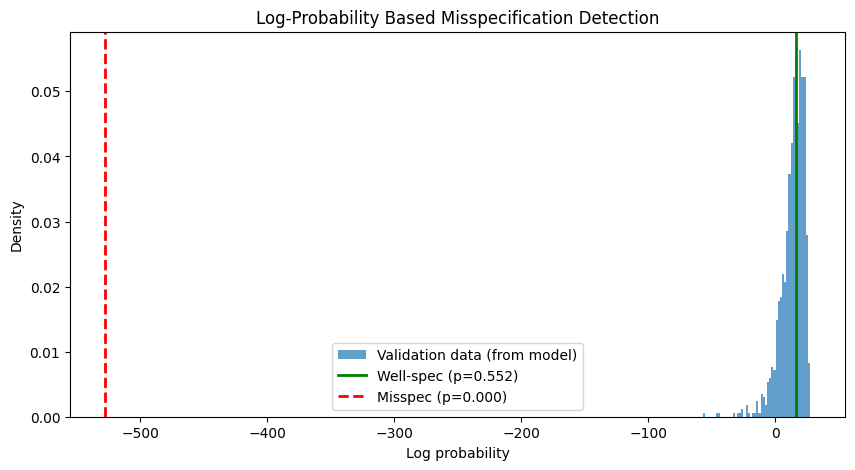

In [15]:
# Visualize log-probability distributions
with torch.no_grad():
    log_probs_val = marginal_estimator.log_prob(x_val).numpy()
    log_prob_wellspec = marginal_estimator.log_prob(x_o_wellspec).item()
    log_prob_misspec = marginal_estimator.log_prob(x_o_misspec).item()

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(log_probs_val, bins=50, alpha=0.7, density=True, label='Validation data (from model)')
ax.axvline(log_prob_wellspec, color='g', linewidth=2, linestyle='-', label=f'Well-spec (p={p_value_wellspec:.3f})')
ax.axvline(log_prob_misspec, color='r', linewidth=2, linestyle='--', label=f'Misspec (p={p_value_misspec:.3f})')
ax.set_xlabel('Log probability')
ax.set_ylabel('Density')
ax.set_title('Log-Probability Based Misspecification Detection')
ax.legend()
plt.show()

### Interpretation

- **p-value ≈ 0.5**: Observation is typical of the model → no evidence of misspecification
- **p-value < 0.05**: Observation is atypical → evidence of misspecification

**Caveat:** Notice the warning above about c2st (classifier two-sample test). A c2st near 1.0 means the marginal estimator didn't learn the distribution well enough (a good estimator should have c2st ≈ 0.5). This is a common challenge: learning $p(x)$ unconditionally is often harder than learning $p(\theta|x)$ conditionally. The results may still be informative, but should be interpreted with care.

## 8. Detection Method 3: MMD-Based Check with Embeddings

**Idea:** Use an embedding network to map data into a latent space, then compute the Maximum Mean Discrepancy (MMD) between the observation and simulated data.

MMD measures the distance between distributions in a kernel space. If $x_o$ is far from the simulated data distribution in embedding space, misspecification is likely.

The `sbi` package provides `calc_misspecification_mmd()` for this. Because NPE learns an embedding network during training, we can reuse it directly!

### Exercise: Use MMD-based detection

Use `calc_misspecification_mmd` to test whether our observations are compatible with the model.

```python
from sbi.diagnostics.misspecification import calc_misspecification_mmd

# API:
p_value, (mmds_baseline, mmd_observed) = calc_misspecification_mmd(
    inference=trainer,      # The trained NPE object
    x_obs=x_o,              # The observation to test
    x=x_val,                # Validation data from the simulator
    mode="embedding"        # Use the learned embedding space
)
```

**Task:** Run the MMD check for both `x_o_wellspec` and `x_o_misspec`. What p-values do you get?

### Solution

In [17]:
from sbi.diagnostics.misspecification import calc_misspecification_mmd

# Test well-specified observation
p_value_mmd_wellspec, (mmds_baseline_wellspec, mmd_wellspec) = calc_misspecification_mmd(
    inference=trainer,
    x_obs=x_o_wellspec,
    x=x_val,
    mode="embedding"  # Use learned embedding space
)
print(f"Well-specified observation (MMD):")
print(f"  p-value: {p_value_mmd_wellspec:.4f}")
print(f"  MMD: {mmd_wellspec:.6f}")

# Test misspecified observation
p_value_mmd_misspec, (mmds_baseline_misspec, mmd_misspec) = calc_misspecification_mmd(
    inference=trainer,
    x_obs=x_o_misspec,
    x=x_val,
    mode="embedding"
)
print(f"\nMisspecified observation (MMD):")
print(f"  p-value: {p_value_mmd_misspec:.4f}")
print(f"  MMD: {mmd_misspec:.6f}")

Well-specified observation (MMD):
  p-value: 0.2850
  MMD: 0.431623

Misspecified observation (MMD):
  p-value: 0.0000
  MMD: 0.763313


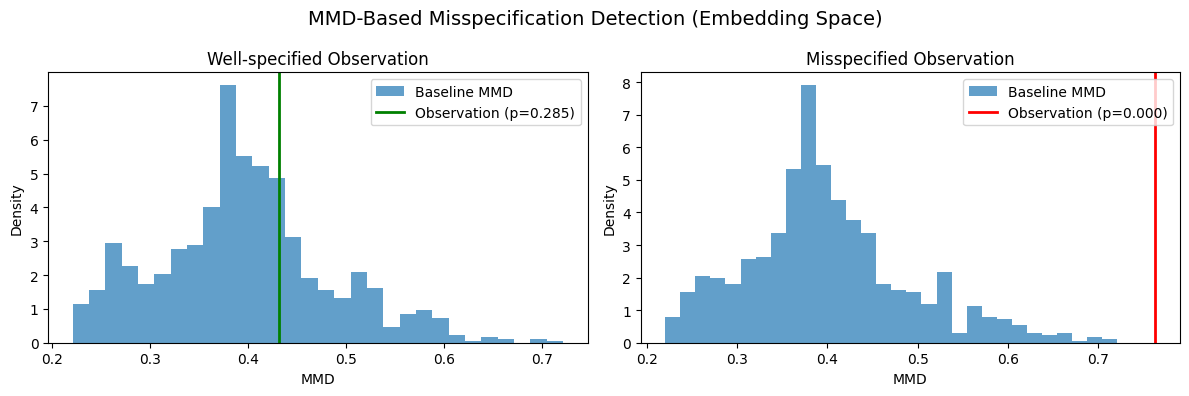

In [18]:
# Visualize MMD distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.hist(mmds_baseline_wellspec, bins=30, alpha=0.7, density=True, label='Baseline MMD')
ax.axvline(mmd_wellspec, color='g', linewidth=2, label=f'Observation (p={p_value_mmd_wellspec:.3f})')
ax.set_xlabel('MMD')
ax.set_ylabel('Density')
ax.set_title('Well-specified Observation')
ax.legend()

ax = axes[1]
ax.hist(mmds_baseline_misspec, bins=30, alpha=0.7, density=True, label='Baseline MMD')
ax.axvline(mmd_misspec, color='r', linewidth=2, label=f'Observation (p={p_value_mmd_misspec:.3f})')
ax.set_xlabel('MMD')
ax.set_ylabel('Density')
ax.set_title('Misspecified Observation')
ax.legend()

plt.suptitle('MMD-Based Misspecification Detection (Embedding Space)', fontsize=14)
plt.tight_layout()
plt.show()

## 9. Summary: Detection Results

Let's summarize what we found:

In [ ]:
print("="*60)
print("MISSPECIFICATION DETECTION SUMMARY")
print("="*60)
print(f"\n{'Method':<25} {'Well-specified':<20} {'Misspecified':<20}")
print("-"*60)
print(f"{'Log-prob p-value':<25} {p_value_wellspec:<20.4f} {p_value_misspec:<20.4f}")
print(f"{'MMD p-value':<25} {p_value_mmd_wellspec:<20.4f} {p_value_mmd_misspec:<20.4f}")
print("-"*60)
print(f"\nInterpretation (α=0.05):")
print(f"  Well-specified: {'No misspecification detected' if p_value_wellspec > 0.05 else 'Misspecification detected!'}")
print(f"  Misspecified:   {'No misspecification detected' if p_value_misspec > 0.05 else 'Misspecification detected!'}")

## 10. Discussion: What To Do When Misspecification Is Detected?

### Option 1: Fix the Simulator (Best if possible!)
- Add the missing mechanism (e.g., Type II functional response)
- Requires domain knowledge and may be complex

### Option 2: Use Robust Inference Methods
- **RNPE (Ward et al., 2022)**: Explicitly model the error between simulator and reality
- **Robust embeddings (Huang & Bharti et al., 2023)**: Learn summary statistics that are insensitive to the mismatch
- **RoPE/FRISBI (Wehenkel et al., 2024)**: Use optimal transport with calibration data

### Option 3: Be Conservative
- Report that misspecification was detected
- Interpret posteriors with appropriate caveats
- Consider broader uncertainty bounds

### Key Takeaway
**Always check for misspecification before trusting your posteriors!**

## Summary

In this notebook, we:

1. **Experienced misspecification**: Saw how NPE posteriors shift when the observation comes from a slightly different process

2. **Learned three detection methods**:
   - **Prior predictive check**: Visual comparison (subjective but interpretable)
   - **Log-probability check**: Compare $\log q(x_o)$ to validation distribution
   - **MMD check**: Compare observation to simulations in embedding space

3. **Key insight**: Detection methods give p-values; low p-values indicate the observation is incompatible with the model

4. **Practical guidance**: 
   - Always run detection before trusting posteriors
   - If misspecification is detected, consider fixing the simulator or using robust methods
   - Report any detected misspecification honestly!

---

**Next steps for the hackathon:**
- Think about what your simulator might be missing
- Run these detection methods on your observations
- If you detect misspecification, come talk to us!